## Modèle


### Installations              

In [ ]:
# Required only for colab environments + GPU
!pip install jax==0.3.25 jaxlib==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# Install required libraries
!pip install -q dalle-mini
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 MB 6.0 MB/s eta 0:00:00
  Created wheel for jax: filename=jax-0.3.25-py3-none-any.whl size=1308492 sha256=276a0f8fd7e0c3651ea0e884327512b15ff08110932db1a674af2b0bac15b03b
  Stored in directory: /root/.cache/pip/wheels/41/0b/45/1acffcaf4c863a6d0d0e910e56ae6502ca8d16300e39e1dab2
Successfully built jax
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.16+cuda11.cudnn86
    Uninstalling jaxlib-0.4.16+cuda11.cudnn86:
      Successfully uninstalled jaxlib-0.4.16+cuda11.cudnn86
  Attempting uninstall: jax
    Found existing installation: jax 0.4.16
    Uninstalling jax-0.4.16:
      Successfully uninstalled jax-0.4.16
ERROR: pip's dependency resolver does not currently take into account all the packages that a

We load required models:
* DALL·E mini for text to encoded images
* VQGAN for decoding images
* CLIP for scoring predictions

In [ ]:
# Model references

# dalle-mega
DALLE_MODEL = "dalle-mini/dalle-mini"  # can be wandb artifact or 🤗 Hub or local folder or google bucket
DALLE_COMMIT_ID = None

# if the notebook crashes too often you can use dalle-mini instead by uncommenting below line
# DALLE_MODEL = "dalle-mini/dalle-mini/mini-1:v0"

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

In [ ]:
import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()

1

In [ ]:
# Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

# Load dalle-mini
model, params = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
)

# Load VQGAN
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID, _do_init=False
)

(…)mini/dalle-mini/resolve/main/config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

(…)83d349bf5d5c41c5b0ef69b677a9/config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/304M [00:00<?, ?B/s]

Model parameters are replicated on each device for faster inference.

In [ ]:
from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)

Model functions are compiled and parallelized to take advantage of multiple devices.

In [ ]:
from functools import partial


# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

Keys are passed to the model on each device to generate unique inference per device.

In [ ]:
import random

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

### Récup data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import json
import pandas as pd

file = open('/content/gdrive/MyDrive/Projet_Multimedia/download/Texte/trans0.txt', encoding='utf-16')
text0 = file.read()
d = json.loads(text0)
file = open('/content/gdrive/MyDrive/Projet_Multimedia/download/Texte/trans1.txt', encoding='utf-16')
text1 = file.read()
d1 = json.loads(text1)
file = open('/content/gdrive/MyDrive/Projet_Multimedia/download/Texte/trans2.txt', encoding='utf-16')
text2 = file.read()
d2 = json.loads(text2)
file = open('/content/gdrive/MyDrive/Projet_Multimedia/download/Texte/trans_rest.txt', encoding='utf-16')
text3 = file.read()
d3 = json.loads(text3)
dictionnary = d | d1
dictionnary = dictionnary | d2
dictionnary = dictionnary | d3
len(dictionnary)
descr = pd.read_csv('/content/gdrive/MyDrive/Projet_Multimedia/download/CSV/Transcription_wav.csv')
name_video = descr['name_vid']
contenue = descr['contenue']
dic = {}
vid_name_set = set()
for vid_name, cont in zip(list(name_video), list(contenue)):
  if not 'artificial intelligence' in cont.lower():
    if not vid_name in dic.keys():
      dic[vid_name] = cont
    else:
      dic[vid_name] += cont
  else:
    vid_name_set.add(vid_name)
    print(vid_name)

def function_reu(x):
  try:
    return dic[x]
  except:
    return ''

def function_test(x):
  try:
    return dictionnary[(x+ '.mp3')]
  except:
    return 'do not have'

descr['descr'] = descr['name_vid'].apply(lambda x : function_reu(x))
descr = descr.drop_duplicates(subset='name_vid')
dt = pd.read_csv('/content/gdrive/MyDrive/Projet_Multimedia/download/CSV/LVT.csv')
dt['name'] = dt['video'].apply(lambda x : x[5:-4])
dt['transcription'] = dt['name'].apply(lambda x : function_test(x))
dt = dt.drop('video', axis=1)
dt = dt[dt.transcription != 'do not have']
intersection = pd.merge(dt, descr, left_on='name', right_on='name_vid')
intersection = intersection.drop('label', axis = 1)
intersection = intersection.drop('Unnamed: 0', axis = 1)
intersection = intersection.drop('name_audio', axis = 1)
intersection = intersection.drop('id_audio', axis = 1)
intersection = intersection.drop('name_vid', axis = 1)
intersection = intersection.drop('contenue', axis = 1)
intersection['total'] = intersection['text'] + intersection['descr'] + intersection['transcription']
print(len(intersection), len(dt), len(descr))

-eOrNdBpGMv8
1551 2085 1878


In [ ]:
dt

,duree,label,text,label_encoded,name,transcription
0,77.60,Entertainment,"cut to Black, Carl a man in a long tan Overcoa...",0,-dXyrxjIcWdw,This has to be the place. No cameras. That's ...
1,318.72,Music,the camera from the helicopter captures the ru...,1,-g0FMrjsYAzc,The beginning part of the season kind of suck...
2,163.42,Education,a blindfold adult wearing green sits next to a...,2,-h7HGWRTGqyg,I'm gonna staple some more. There we go. Good...
3,125.02,Film & Animation,"a man doing a trick in the air, Robert Downey ...",3,-eOrNdBpGMv8,You were made to be ruled. In the end... It w...
4,171.74,Film & Animation,crisp white text Upon A moonlit background Ree...,3,-dRaKMNYG3-I,You I I'm sorry. You I I Oh You You
...,...,...,...,...,...,...
2094,190.03,Entertainment,the supermarket spray logo appears on the scre...,0,--UggNH1YeRY,You're watching the Game Show Network. I watc...
2095,55.50,Education,Barbara grabs a red cup from her right and put...,2,--kNSaU8L3mI,"For another child, even something like notici..."
2096,158.59,Entertainment,"dad Smiles his lips move when he speaks, the m...",0,-0-NBRA1aSXk,Music Dad Dad Dad. Dad. Dad. Dad. Dad has voi...
2097,108.62,People & Blogs,add 3 cups of flour a teaspoon of salt and a t...,4,--bCmuE3KxWI,Music you you you you


### Text Prompt

Our model requires processing prompts.

In [ ]:
from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

(…)-mini/resolve/main/tokenizer_config.json:   0%|          | 0.00/497 [00:00<?, ?B/s]

(…)-mini/dalle-mini/resolve/main/vocab.json:   0%|          | 0.00/802k [00:00<?, ?B/s]

(…)-mini/dalle-mini/resolve/main/merges.txt:   0%|          | 0.00/461k [00:00<?, ?B/s]

(…)i/dalle-mini/resolve/main/tokenizer.json:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

(…)ini/resolve/main/special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

enwiki-words-frequency.txt:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

Let's define some text prompts.

In [ ]:
liste_prompt = []
def recup_prompt(name) :
  desc = dt[dt['name'] == name].text.values[0]
  liste_prompt.append(desc.split(','))

dt['name'].apply(lambda x : recup_prompt(x))
prompts = liste_prompt[0]

In [ ]:
prompts

['cut to Black',
 ' Carl a man in a long tan Overcoat enters he is looking around',
 ' car looks in the small window set in the door then pulls back',
 ' Carl pulls a card out of his pocket sliding it between the door and the door frame opening the door',
 ' Carl approaches the door inspecting one of the potted plants',
 ' Carl goes through the door and close it behind him',
 ' the back door of a building there is a small rectangular window set in the door and a potted plant on either side of the door',
 ' end card reads subscribe to Dad what does Carl want their video links to obey the server lyric video and Dad upload']

Note: we could use the same prompt multiple times for faster inference.

In [ ]:
#tokenized_prompts = [processor(prompt) for prompt in prompts]
tokenized_prompts = processor(prompts)

Finally we replicate the prompts onto each device.

In [ ]:
tokenized_prompt = replicate(tokenized_prompts)

## Génération d'images

We generate images using dalle-mini model and decode them with the VQGAN.

In [ ]:
# number of predictions per prompt
n_predictions = 1

# We can customize generation parameters (see https://huggingface.co/blog/how-to-generate)
gen_top_k = None
gen_top_p = None
temperature = None
cond_scale = 10.0

Prompts: ['cut to Black', ' Carl a man in a long tan Overcoat enters he is looking around', ' car looks in the small window set in the door then pulls back', ' Carl pulls a card out of his pocket sliding it between the door and the door frame opening the door', ' Carl approaches the door inspecting one of the potted plants', ' Carl goes through the door and close it behind him', ' the back door of a building there is a small rectangular window set in the door and a potted plant on either side of the door', ' end card reads subscribe to Dad what does Carl want their video links to obey the server lyric video and Dad upload']



  0%|          | 0/1 [00:00<?, ?it/s]

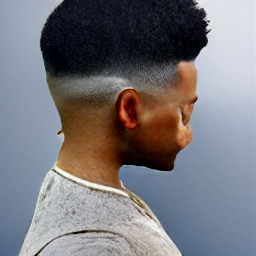

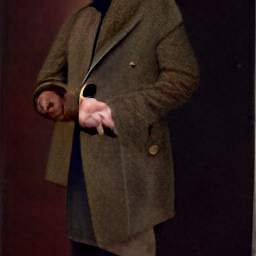

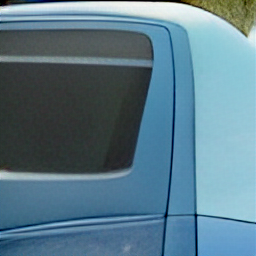

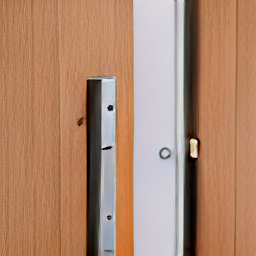

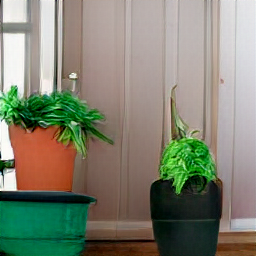

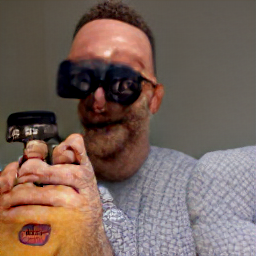

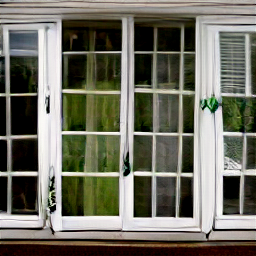

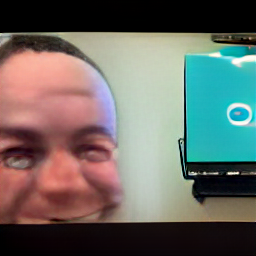

In [ ]:
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange

print(f"Prompts: {prompts}\n")
# generate images
images = []
for i in trange(max(n_predictions // jax.device_count(), 1)):
    # get a new key
    key, subkey = jax.random.split(key)
    # generate images
    encoded_images = p_generate(
        tokenized_prompt,
        shard_prng_key(subkey),
        params,
        gen_top_k,
        gen_top_p,
        temperature,
        cond_scale,
    )
    # remove BOS
    encoded_images = encoded_images.sequences[..., 1:]
    # decode images
    decoded_images = p_decode(encoded_images, vqgan_params)
    decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
    for decoded_img in decoded_images:
        img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
        images.append(img)
        display(img)
        print()

## Evaluer les images ave le score CLIP

In [ ]:
# CLIP model
CLIP_REPO = "openai/clip-vit-base-patch32"
CLIP_COMMIT_ID = None

# Load CLIP
clip, clip_params = FlaxCLIPModel.from_pretrained(
    CLIP_REPO, revision=CLIP_COMMIT_ID, dtype=jnp.float16, _do_init=False
)
clip_processor = CLIPProcessor.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)
clip_params = replicate(clip_params)


# score images
@partial(jax.pmap, axis_name="batch")
def p_clip(inputs, params):
    logits = clip(params=params, **inputs).logits_per_image
    return logits

(…)it-base-patch32/resolve/main/config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/605M [00:00<?, ?B/s]

(…)32/resolve/main/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

(…)tch32/resolve/main/tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

(…)vit-base-patch32/resolve/main/vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

(…)vit-base-patch32/resolve/main/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)base-patch32/resolve/main/tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

(…)h32/resolve/main/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
from flax.training.common_utils import shard

# get clip scores
clip_inputs = clip_processor(
    text=prompts * jax.device_count(),
    images=images,
    return_tensors="np",
    padding="max_length",
    max_length=77,
    truncation=True,
).data
logits = p_clip(shard(clip_inputs), clip_params)

# organize scores per prompt
p = len(prompts)
logits = np.asarray([logits[:, i::p, i] for i in range(p)]).squeeze()

TypeError: ignored

In [ ]:
images

[<PIL.Image.Image image mode=RGB size=256x256>,
 <PIL.Image.Image image mode=RGB size=256x256>,
 <PIL.Image.Image image mode=RGB size=256x256>,
 <PIL.Image.Image image mode=RGB size=256x256>,
 <PIL.Image.Image image mode=RGB size=256x256>,
 <PIL.Image.Image image mode=RGB size=256x256>,
 <PIL.Image.Image image mode=RGB size=256x256>,
 <PIL.Image.Image image mode=RGB size=256x256>,
 <PIL.Image.Image image mode=RGB size=256x256>,
 <PIL.Image.Image image mode=RGB size=256x256>]

Affichage des images en fonction du CLIP score.

Prompt: the camera from the helicopter captures the rugged terrain of the mountains as well as trees



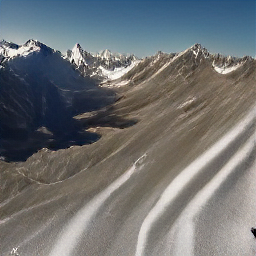

Score: 24.94



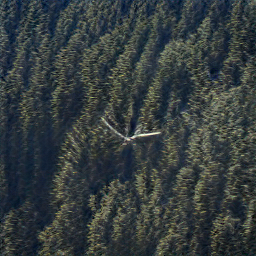

Score: 24.46


Prompt:  the video flips back to the notebook this time saying avalanches and survival underneath it says the snowpack is questionable and there has been some movement on the spine lines when everything cracks out in front of you instincts kick in.



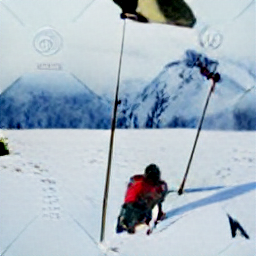

Score: 29.59



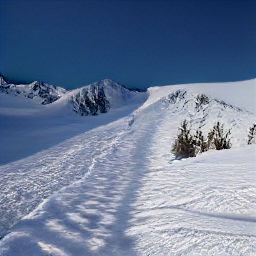

Score: 25.90


Prompt:  the helicopter touches down on the top of the mountain and he gets out on his skis



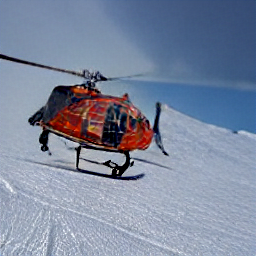

Score: 27.98



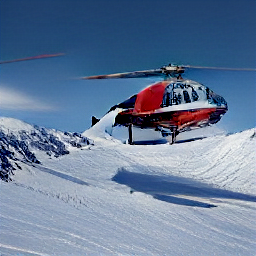

Score: 25.46


Prompt:  the helicopter touches down onto the mountain and he gets out and grabs his keys



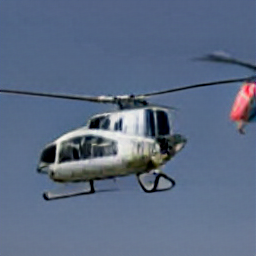

Score: 28.56



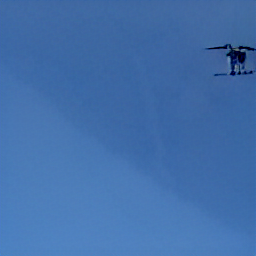

Score: 28.54


Prompt:  a small Avalanche curves



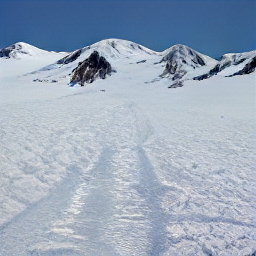

Score: 28.98



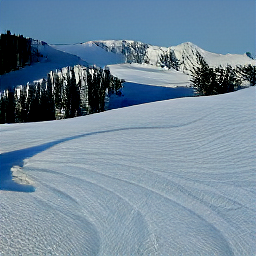

Score: 23.34




In [ ]:
for i, prompt in enumerate(prompts):
    print(f"Prompt: {prompt}\n")
    for idx in logits[i].argsort()[::-1]:
        display(images[idx * p + i])
        print(f"Score: {jnp.asarray(logits[i][idx], dtype=jnp.float32):.2f}\n")
    print()